# Unsupervised Symmetry-Preserving Feature Learning


## Introduction

We demonstrate an unsupervised method of learning feature vector representation that preserves physical symmetries. To achieve this goal, we adopted the approach presented in A. Dosovitskiy et al. _Discriminative Unsupervised Feature Learning with Exemplar Convolutional Neural Networks_ (2014), https://arxiv.org/abs/1406.6909. We test this approach on input representing a numerical simulation of the Spinodal Decomposition model.

### Scope of the work

 1. We load and describe the input data.
 2. As a baseline, we calculate the feature vectors using a pretrained ResNet-v2 model. We demonstrate the clustering results and we discuss some potential imperfections of that particular vector representation.
 3. We propose an augmentation procedure, that leverages symmetries of our problem.
 4. We train several classifiers, assuming that each data-point consists of its own class. We compare different vector representation, testing if the arrangements of the instances in the latent space reflect the variation of the initial parameters.
 5. We compare the clustering results using different feature vector representations.

### The Background

We would like to learn a good vector representation of our high-dimensional input. Models that were pre-trained on labeled datasets (like ImageNet) might produce a reasonable results. However, due to the fact that our data come from vastly-different domain (ImageNet contains picture of common objects and animals, while our dataset represents results of numerical simulations), the standard feature representation is unlikely to capture all essential symmetries of our input. This work shows how to prepare a model, capable of mapping the input to a feature (latent) space, that was train to respect the underlaying symmetries of the physical system.

### Library Imports

We will pre-load all libraries that we will use in that notebook.

The notebook was tested with python 3.8, CUDA 10.1 and with the following package versions:

    Package                           Version
    --------------------------------- ----------
    numpy                             1.18.5
    pandas                            1.1.5
    scikit-image                      0.18.0
    scikit-learn                      0.23.2
    scipy                             1.4.1
    tensorflow-gpu                    2.3.0
    tensorflow-hub                    0.10.0

In [1]:
# Standard libraries
import collections
import os
import json
import random
import sys
import time

# Libraries you must install (e.g. using pip install name_of_the_library)
import math
import numpy
import pandas
import scipy
import skimage.measure
import skimage.transform
import sklearn.datasets
import sklearn.model_selection
import sklearn.linear_model
import sklearn.cluster
import tensorflow
import tensorflow_hub

# Error levels, see https://github.com/tensorflow/tensorflow/issues/37876
tensorflow.get_logger().setLevel("ERROR")

# Graphic libraries
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

## Section 1: Imput Data

All the input data can be found at the ISI server `effectbig03` in the `/data/mjabram/share/spinodal_decomposition` folder.

### The Training Data

See the _Spinodal Decomposition (Part 1)_ notebook to learn more about the preprocessing steps that we applied to the raw data.

We will load the last frames of the training simulations. Note, that those frames consists of 256x256 one-color-channel pictures.

In [2]:
# If you run this notebook localy, change the path so it match the location of your main data folder
DATA_PATH = '/raw/cah/shared/'

In [3]:
# Load the training data
channel1 = numpy.load(os.path.join(DATA_PATH, 'cah_lastframe_train5000x_256f16.npy')).astype('float32')

# Standarize the input data
channel1 = numpy.where(channel1 > 1, 1, channel1)
channel1 = numpy.where(channel1 < -1, -1, channel1)
channel1 += 1
channel1 /= 2

channel1.shape, channel1.dtype

((4998, 256, 256, 1), dtype('float32'))

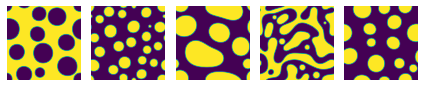

In [4]:
def plot_frames(data, *arr, cmap='viridis', title=None, axis=None):
    """Plot selected frames."""
    if title:
        print(title)
    fig, axes = plt.subplots(1, len(arr))
    for i, k in enumerate(arr):
        a = axes if len(arr) == 1 else axes[i]
        if not axis:
            a.axis('off');
        fig.tight_layout() 
        a.imshow(data[k], cmap=cmap)
    plt.show()

# Plot last frames from a few simulations
plot_frames(channel1, 0, 1, 2, -2, -1)

### The Labels

Looking at the simulations, we can notice that there are two obvious classes: one where the positive phase is dominant (yellow background, purple "bubbles") and another where the negative phase is dominant (purple background, yellow "bubbles"). However, as you can see below, we have also cases, that can not be easily accounted to one of those two classes.

We generated labels, checking if there is a path connecting pixels of one color from one edge to another edge. Specifically, we check if there is:
 - a vertical connection `v`. We say that there is such a connection, if there exists `k` for which there is a connected path of one color from `(0, k)` to `(n-1, k)`.
 - a horizontal connection `h`. We say that there is such a connection, if there exists `k` for which there is a connected path of one color from `(k, 0)` to `(k, n-1)`.
 
We assumed, that the connected path can be traveled only in vertical or horizontal directions. Meaning, that two pixels of one color that share one common corner are not connected.
 
We checked those connections with respect to:
 - both, negative phase (denoted as `neg` or `B`, and usually depicted by a purple color) and positive phase (denoted as `pos` or `A`, and usually depicted by a yellow color).
 - both, using and not-using the fact, that we have periodic boundary conditions (denoted below as `pbc`).

In [5]:
# Load and show the labels
connectivity = pandas.read_csv(os.path.join(DATA_PATH, 'cah_lastframe_train5000c_256f16.csv'))

# Mark "spanning clusters" (sc), dominant positive (+), and dominant negative (-) cases
connectivity['sc'] = [int(row.pos != 'hv' and row.neg != 'hv') for _, row in connectivity.iterrows()]
connectivity['+'] = [int(row.pos == 'hv' and row.neg != 'hv') for _, row in connectivity.iterrows()]
connectivity['-'] = [int(row.pos != 'hv' and row.neg == 'hv') for _, row in connectivity.iterrows()]

connectivity.tail()

,pos,neg,pos_pbc,neg_pbc,sc,+,-
4993,0,hv,0,hv,0,0,1
4994,hv,0,hv,0,0,1,0
4995,hv,0,hv,0,0,1,0
4996,0,0,hv,hv,1,0,0
4997,0,hv,0,hv,0,0,1


To read more about the Spanning Clusters (SC), check _Spinodal Decomposition (Part 1)_ and _Spinodal Decomposition (Part 2)_.

### Second Channel

Later, we will like to use such models as ResNet-50 or ResNet-34. The first layer in those models has no bias and uses `relu` activation function. It means, that in principle, the positive patches are not treated necessarily in the same way as the negative patches. Therefore, to make sure that we have symmetry and we do not treat positive or negative phases differently, we add second channel where the roles of positive and negative phases are reversed.

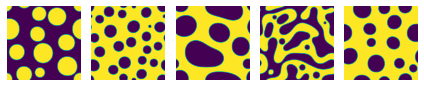

(4998, 256, 256, 1)

In [6]:
# Add second chanel
channel2 = 1 - channel1

# Plot a few examples
plot_frames(channel2, 0, 1, 2, -2, -1)
channel2.shape

### The Third Channel

To use models pre-trained on ImageNet, we usually need three-channel input. We do not want to break the symmetry between the positive and negative phases: so far, we have one channel with positive phase encoded as +1 and the negative as -1, and a second channel where the positive phase is encoded as -1 and the negative phase as +1. Here, we propose a third channel, that encodes only the shapes without the information if the patches contain positive or negative phase. Filters that will use that particular channel as their input will be forced to focus only on extracting information about the shape and size of different "bubbles" (since the color information will be missing).

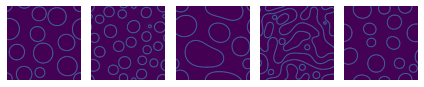

(4998, 256, 256, 1)

In [7]:
# The third chanel
channel3 = 1 - 2*numpy.abs(channel1 - 0.5)

# Plot a few examples
plot_frames(channel3, 0, 1, 2, -2, -1)
channel3.shape

### Parameters

We load the initial parameters. There are three values for each simulation: the mobility of the phase A, `mobA`, the mobility of the phase B, `mobB`, and the phase fraction, `frac`.

The initial parameters were selected from uniform distributions. Mobility of the A and B phase were selected from `U(0, 100)`, while the phase fraction was selected from `U(-0.4, 0.4)`.

The phase fraction is defined as `frac = phase A concentration - phase B concentration` with the constraint `phase A concentration + phase B concentration = 1`.

Again, for detail analysis, see _Spinodal Decomposition (Part 1)_. We described there, among others, a small discrepancy between the declared phase concentration and the measured one. However, we believe that this should not effect in any significant way the results of this analysis.

In [8]:
# Load the parameters
parameters = numpy.load(os.path.join(DATA_PATH, 'cah_lastframe_train5000p_256f16.npy'))
parameters = pandas.DataFrame(data=parameters, columns=['mobA', 'mobB', 'frac'])
parameters.tail()

,mobA,mobB,frac
4993,67.035086,46.664670,-0.158747
4994,94.223735,98.272281,0.148099
4995,2.031358,43.635881,0.238011
4996,14.542157,0.946535,0.029123
4997,18.476629,84.828663,-0.374032


## Section 2: Baseline Model

To create feature vector from an image, we can use one of the pre-trained models available in the TensorFlow Hub. Here, we decided to use the **ResNet-50 V2** model. The key difference between the V1 and V2 models is the use of batch normalization. ResNet-50 has `50` layers and was trained on standard ImageNet-1k detaset (ILSVRC-2012-CLS). The feature vector has size `2048`. The input images are expected to have color values in the range `[0,1]` and the expected size of the input images is `224x224` pixels by default, but other input sizes are possible (within limits). See more at https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4.

### The Feature Vector

Note, that this model require 3-channel input. Therefore, we will just triple our single-channel frames using the `numpy.repeat` function.

```python
model = tensorflow.keras.Sequential([
    tensorflow_hub.KerasLayer(
        "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4",
        trainable=False),
])
model.build([None, 256, 256, 3])
```

The features can be computed by the following code:
```python
features_channel1 = model.predict(numpy.repeat(channel1, 3, axis=-1))
features_channel2 = model.predict(numpy.repeat(channel2, 3, axis=-1))
features_channel3 = model.predict(numpy.repeat(channel3, 3, axis=-1))
```

In [9]:
# To save the time, we will load the (already pre-computed) feature vectors from the disk
features_channel1 = numpy.load(
    os.path.join(DATA_PATH, 'cah_lastframe_train5000f_256f16_ResNetV2_single_channel1.npy'))
features_channel2 = numpy.load(
    os.path.join(DATA_PATH, 'cah_lastframe_train5000f_256f16_ResNetV2_single_channel2.npy'))
features_channel3 = numpy.load(
    os.path.join(DATA_PATH, 'cah_lastframe_train5000f_256f16_ResNetV2_single_channel3.npy'))

### Baseline Clustering

For the clustering method, we choose K-Means algorithm. We use `k-means++` algorithm to select the initial positions of the centroids, cf. David Arthur and Sergei Vassilvitskii, _k-Means++: The Advantages of Careful Seeding_ (2007). Each time, we run the algorithm several time and we chose the results that correspond to the lowest inertia.

For the baseline clustering, we will use only the original one-channel data (see also the main Spinodal Decomposition notebooks for more details).

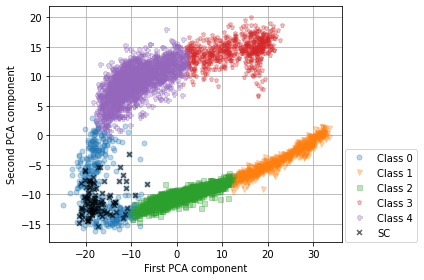

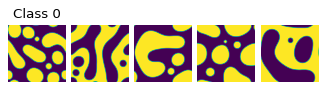

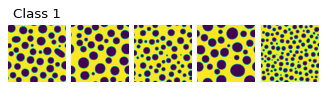

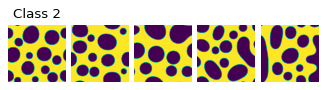

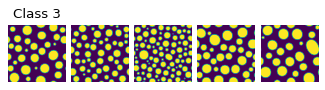

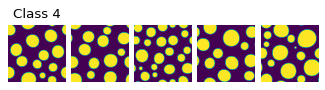

In [10]:
def plot_clusters(fig, ax, k, instances, labels, legend=True, title=None, sc=connectivity.sc,
                  xtitle='First PCA component', ytitle='Second PCA component'):
    """Plot Clusters."""
    markers = ['o', 'v', 's', 'p', 'P', '*', 'd']
    
    for i in range(k):
        x = instances[labels == i, 0]
        y = instances[labels == i, 1]
        ax.plot(
            x, y, marker=markers[i], linestyle="", label=f'Class {i}',
            markersize=5, alpha=0.3)
    
    # Mark the SC instances
    if sc is not None:
        x = instances[sc == 1, 0]
        y = instances[sc == 1, 1]
        ax.plot(
            x, y, marker='x', linestyle="", label='SC', alpha=0.6,
            color='black', markeredgewidth=1.5, markersize=5)
    
    ax.set_xlabel(xtitle)
    ax.set_ylabel(ytitle)
    if legend:
        ax.legend(loc=(1.01, 0));
    if title:
        ax.title.set_text(title)
    ax.grid(); fig.tight_layout()
    
    
def plot_classes(img, labels, width=5, shuffle=False):
    """Plot figures."""
    classes = set(labels)
    
    for c in classes:
        selected = img[labels == c]
        
        if shuffle:
            numpy.random.shuffle(selected)
            
        selected = selected[:width][:,:,:,0]

        fig, axes = plt.subplots(1, width, dpi=80, figsize=(width, 1))
        for i, m in enumerate(selected):
            axes[i%width].imshow(m)
            axes[i%width].axis('off')
            if i == 0:
                axes[i%width].set_title(f'Class {c}')
            
        fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)


# Cluster the data (first channel only)
kmeans = sklearn.cluster.KMeans(
    n_clusters=5, n_init=1, init='k-means++', random_state=321).fit(features_channel1)
kmeans_labels_resnet50 = kmeans.labels_

# Reduce the dimensionality
reduced = sklearn.decomposition.PCA(
    n_components=2).fit_transform(features_channel1)

# Plot the results
fig, axes = plt.subplots(1, 1)
plot_clusters(
    fig, axes, k=5, instances=reduced, labels=kmeans_labels_resnet50, legend=True)

# Plot a few random examples from each class
numpy.random.seed(321)
plot_classes(channel1, labels=kmeans_labels_resnet50, width=5, shuffle=True)

**Interpretation:** We got a quite clear separation between cases with positive and negative value of the `frac` parameter, as well as separation with respect to the characteristic size of the micro-structures.
 - Class 0 contains examples, where there is a balance between the positive and the negative phases (`frac` close to 0).
 - Class 1 contains examples, where positive phase is dominant (`frac > 0`) and where mobility of the positive phase is small (`mobA << 100`).
 - Class 2 contains examples, where positive phase is dominant (`frac > 0`) and where mobility of the positive phase is large (`mobA >> 0`).
 - Class 3 contains examples, where negative phase is dominant (`frac < 0`) and where mobility of the negative phase is small (`mobB << 100`). 
 - Class 4 contains examples, where negative phase is dominant (`frac < 0`) and where mobility of the negative phase is large (`mobB >> 0`).

### Single Channel Feature Vectors

We further analyze the feature vectors that we obtained using the single-channel inputs. We would expect, that there should be no difference between `features_channel1` and `features_channel2` (since we only switched the positive and negative phases; all the shapes remained the same). We further expect, that clustering based on the `features_channel3` vector should grasp only the size and shape of the structures and be indifferent to the phase sign.

We plot the instances along the first two principal directions. We mark the positive and the negative instances (here, orange points indicate inputs with the positive phase being dominant, and the blue points show inputs where the negative phase is dominant).

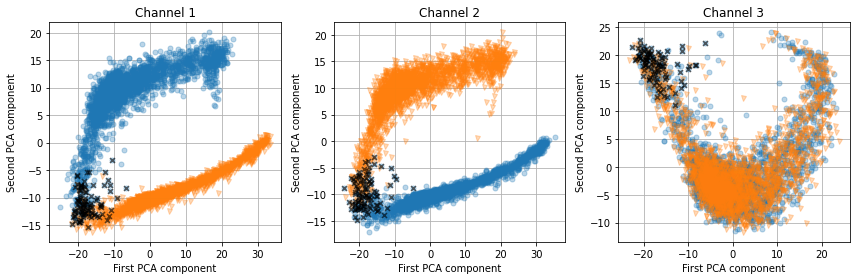

In [11]:
# Reduce the dimensionality
reduced1 = sklearn.decomposition.PCA(n_components=2).fit_transform(features_channel1)
reduced2 = sklearn.decomposition.PCA(n_components=2).fit_transform(features_channel2)
reduced3 = sklearn.decomposition.PCA(n_components=2).fit_transform(features_channel3)

# Plot the results
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
plot_clusters(
    fig, axes[0], k=2, instances=reduced1, title='Channel 1',
    labels=connectivity['+'], legend=False)
plot_clusters(
    fig, axes[1], k=2, instances=reduced2, title='Channel 2',
    labels=connectivity['+'], legend=False)
plot_clusters(
    fig, axes[2], k=2, instances=reduced3, title='Channel 3',
    labels=connectivity['+'], legend=False)

**Interpretation:** The results are as expected. Only the first and second channel can be used to distinguish between the cases where positive or negative phase is dominant. However, note that the "arms" in the two first figures are not symmetric. Even after we flipped the positive and negative phase, the shape of the occupied region in the latent space didn't change. This can be also expected: one possible explanation is, that ResNet does not treat positive and negative regions in the same way, as we discussed it before. Therefore, instead of "black bubles on the white background" vs. "white bubles on the black background", ResNet see the input more like "white bubles" vs. "white plane with holes".

Now we will plot the same figures, marking the value of the mobility parameter.

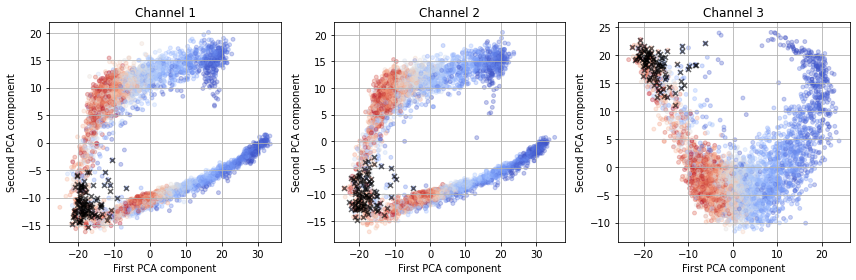

In [12]:
def plot_pca(fig, ax, k, instances, color, sc=connectivity.sc, title=None,
             xtitle='First PCA component', ytitle='Second PCA component'):
    """Plot with color as third dimension."""
    x = instances[:,0]
    y = instances[:,1]
    
    ax.scatter(
        x, y, marker='o', c=color,
        cmap=plt.cm.coolwarm, s=15, alpha=0.3)
        
    # Mark the SC instances
    if sc is not None:
        x = instances[sc == 1, 0]
        y = instances[sc == 1, 1]
        ax.plot(
            x, y, marker='x', linestyle="", label='SC', alpha=0.6,
            color='black', markeredgewidth=1.5, markersize=5)
    
    if title:
        ax.title.set_text(title)
    ax.set_xlabel(xtitle)
    ax.set_ylabel(ytitle)
    ax.grid(); fig.tight_layout()
    
    
# Plot the results
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
color_value = numpy.where(parameters.frac > 0, parameters.mobA, parameters.mobB)
plot_pca(fig, axes[0], k=2, instances=reduced1, color=color_value, title='Channel 1')
plot_pca(fig, axes[1], k=2, instances=reduced2, color=color_value, title='Channel 2')
plot_pca(fig, axes[2], k=2, instances=reduced3, color=color_value, title='Channel 3')

**Interpretation:** That we have two mobilities: mobility of the positive phase `mobA` and mobility of the negative phase `mobB`. Here, using colors from blue (low values) to red (high values), we marked the mobility of the dominant phase, note the code `numpy.where(parameters.frac > 0, parameters.mobA, parameters.mobB)`.

We see that in all three cases we can clearly separate the instances for which mobility of the dominant phase is low or high. Black crosses denotes the SC instances. They are grouped in the region where `frac` is close to zero.

### Three Channel Mapping

Now we put all the three channels together and we use ResNet-50-V2 network to compute new feature vectors.

We can arbitrarily pick the order of the channels. To verify if the order choice influences our results, we test the following two sequences, `[123]` and `[321]`. We used the following code:

```python
features_channels123 = model.predict(
    numpy.concatenate([channel1, channel2, channel3], axis=-1)
)

features_channels321_reversed = model.predict(
    numpy.concatenate([channel3, channel2, channel1], axis=-1)
)
```

In [13]:
# To save the computational time, we load the pre-computed vectors from the disk
features_channels123 = numpy.load(
    os.path.join(DATA_PATH, 'cah_lastframe_train5000f_256f16_ResNetV2_channels123.npy'))

features_channels321 = numpy.load(
    os.path.join(DATA_PATH, 'cah_lastframe_train5000f_256f16_ResNetV2_channels321.npy'))

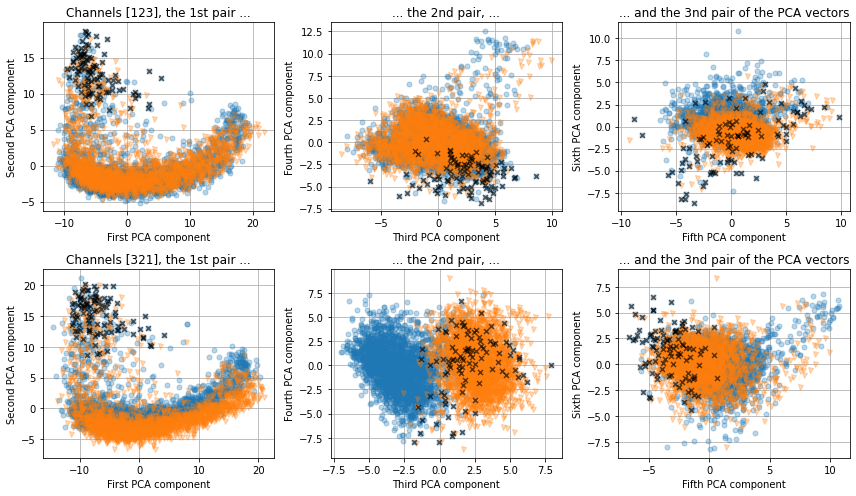

In [14]:
# Reduce the dimensionality
reduced123 = sklearn.decomposition.PCA(n_components=10).fit_transform(features_channels123)
reduced321 = sklearn.decomposition.PCA(n_components=10).fit_transform(features_channels321)

# Plot the results (channel [123])
fig, axes = plt.subplots(2, 3, figsize=(12, 7))
plot_clusters(
    fig, axes[0][0], k=2, instances=reduced123, title='Channels [123], the 1st pair ...',
    labels=connectivity['+'], legend=False)
plot_clusters(
    fig, axes[0][1], k=2, instances=reduced123[:,2:], title='... the 2nd pair, ...',
     xtitle='Third PCA component', ytitle='Fourth PCA component',
    labels=connectivity['+'], legend=False)
plot_clusters(
    fig, axes[0][2], k=2, instances=reduced123[:,4:], title='... and the 3nd pair of the PCA vectors',
     xtitle='Fifth PCA component', ytitle='Sixth PCA component',
    labels=connectivity['+'], legend=False)

# Plot the results (channel [321])
plot_clusters(
    fig, axes[1][0], k=2, instances=reduced321, title='Channels [321], the 1st pair ...',
    labels=connectivity['+'], legend=False)
plot_clusters(
    fig, axes[1][1], k=2, instances=reduced321[:,2:], title='... the 2nd pair, ...',
     xtitle='Third PCA component', ytitle='Fourth PCA component',
    labels=connectivity['+'], legend=False)
plot_clusters(
    fig, axes[1][2], k=2, instances=reduced321[:,4:], title='... and the 3nd pair of the PCA vectors',
     xtitle='Fifth PCA component', ytitle='Sixth PCA component',
    labels=connectivity['+'], legend=False)

**Interpretation:** In the figures above, we plotted the results using the first three pairs of the most important principal directions. The first plots on left looks similar. However, looking in the direction of the second and third pair of principal axis, we see a significant difference. By using the 3-2-1 sequence, we get a clear separation between the positive and the negative cases already in the third principal direction. In contrast, by using the 1-2-3 sequence, we have only a partial separation of those cases along the sixth principal direction.

The channels in the ResNet-50-V2 are clearly not treated equally and we get different results depending on the sequence of the channels that we used. This illustrates the potential disadvantage of using models that were trained on different domain (there might be a statistical difference between the red and the blue edges in the pictures of real objects and animals, while in our case we would expect a full symmetry with respect to the channel order).

## Section 3: Data Augmentation

In the next section, we will assume, that each training instance has its own unique, individual label. Therefore, to train a classifier, a heavy augmentation will be needed. In our case, we use the periodic boundary conditions and rotational isotropy of the space. Namely,
 - We translate the image by a random vector _v_ between [0, 0] and [255, 255].
 - We rotate the image by a random angle from 0 to 360 degree.
 - We crop the central part of the image (of size 128x128). In such a way, we do not have to worry about the "black" corners that we got by rotating the image.

By augmenting data in such a way, the model will learn to be invariant to the described transformations.

In the _Discriminative Unsupervised Feature Learning with Exemplar Convolutional Neural Networks (2014)_, https://arxiv.org/abs/1406.6909, the authors reported, that the best results can be achieved using 4000-8000 classes and more then 64 samples per class. We tested several configurations: namely with 64/64 classes/samples, as well as with 128/64, 256/64, 512/64, 256/128, and 512/128. The results suggest, that already a couple of hundreds classes is enough to learn a good feature representation in our case. This can be explain by the fact that the intrinsic dimensionality (ID) of our our input is much smaller than the ID of natural pictures. Our domain contains only "bubbles" of various shape and size, most pixels have extreme values (either 0 or 1), finally there is a symmetry between the two first channels. it seems, that by sampling just 128 or 256 images, we can adequate probe the entire data manifold. In contrast, the examples from CIFAR-10 or Caltech-256 represent various real-world objects and their ID parameter is larger. Consequently, more classes are needed to probe the corresponding data manifold.

Additionally, by the way how we implemented the Early Stop procedure, if we use more then 128 samples per class, the validation set becomes strongly correlated with the training set. Therefore, below, we restricted ourselves only to 64 training samples per class.

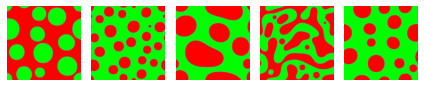

(4998, 256, 256, 3)

In [15]:
# Put all three channels together
data3 = numpy.concatenate([channel1, channel2, channel3], axis=-1)

# Plot a few examples from the third chanel
plot_frames(data3, 0, 1, 2, -2, -1)
data3.shape

In [16]:
# Create the auxiliary labels
NO_AUXILIARY_CLASSES = 256

auxiliery_labels = numpy.array(range(NO_AUXILIARY_CLASSES))
auxiliery_labels = tensorflow.one_hot(auxiliery_labels, NO_AUXILIARY_CLASSES).numpy()
auxiliery_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [17]:
def roll(s, i, j):
    """Offset the input by i, j using periodic boundary conditions."""
    s = numpy.roll(s, i, axis=0)
    s = numpy.roll(s, j, axis=1)
    return s


def augment(images, labels, aux, repetitions=1):
    """Augment the data."""
    d, y, s = [], [], []
    for img, lab, a in zip(images, labels, aux.sc):
        for i, j in numpy.random.randint(256, size=(repetitions, 2)):
            x = roll(img, i=i, j=j)
            x = skimage.transform.rotate(x, numpy.random.random()*360)
            x = x[64:256-64,64:256-64]  # min is 38
            d.append(x)
            y.append(lab)
            s.append(a)
            
    d = numpy.array(d)
    y = numpy.array(y)
    s = numpy.array(s)   

    return d, y, s


# Create a training set
SAMPLES_PER_CLASS = 64
numpy.random.seed(123)
permutation = numpy.random.permutation(len(data3))
train_data, train_y, train_aux = augment(
    data3[permutation][:NO_AUXILIARY_CLASSES*SAMPLES_PER_CLASS],
    auxiliery_labels, connectivity, repetitions=SAMPLES_PER_CLASS)

# Create validation set
val_data, val_y, val_aux = augment(
    data3[permutation][:NO_AUXILIARY_CLASSES*SAMPLES_PER_CLASS],
    auxiliery_labels, connectivity, repetitions=1)

train_data.shape, train_y.shape, val_data.shape, val_y.shape

((16384, 128, 128, 3), (16384, 256), (256, 128, 128, 3), (256, 256))

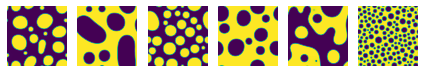

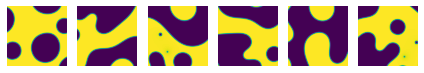

In [18]:
# Plot some examples from the original dataset and from the augmented training set
plot_frames(data3[permutation][:,:,:,0], 19, 20, 21, 22, 23, 24)
plot_frames(train_data[:,:,:,0], 23*64-1, 23*64, 23*64+1, 23*64+2, 23*64+3, 23*64+4)

**Interpretation:** In the upper row, we plotted examples from the original (not augmented) dataset. In the lower row we printed a few examples from the augmented dataset. Note, that the examples from 2nd to 6th from the bottom row consists of rotated patches taken from the 5th picture from the upper row.

## Section 4: Model Training

First, we train several classifier using our augmented training dataset. Then, we remove the last layer of the network and we calculate the feature vectors using the original (not augmented) input data.

With large number of classes, it is expected that the model can confuse similar instances. Especially here, when we work with outputs of numerical calculations. Simulations computed with similar starting parameters have output that are very similar to each other. Therefore, it is reasonable to expect, that the top-1 accuracy can be quite low. Therefore, to get better intuition how our models perform, we measure here also the top-5 accuracy.

Note, that our original input is 4 times larger (256x256) then the augmented data (128.128). Therefore, we make inference for each patch and we average the results for each path.

### Simple CNN

We start by implementing the same architecture as that described in the _Discriminative Unsupervised Feature Learning with Exemplar Convolutional Neural Networks (2014)_, https://arxiv.org/abs/1406.6909. It's a simple CNN with three convolutional layers 5x5 and a single densely connected hidden layer.

In [19]:
# Define the model
m1 = tensorflow.keras.models.Sequential()
m1.add(tensorflow.keras.layers.Conv2D(
    input_shape=(128, 128, 3), filters=64, strides=2, 
    kernel_size=(5, 5), padding="same", activation="relu"))
m1.add(tensorflow.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

m1.add(tensorflow.keras.layers.Conv2D(
    filters=128, kernel_size=(5, 5), strides=1, padding="same", activation="relu"))
m1.add(tensorflow.keras.layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2)))

m1.add(tensorflow.keras.layers.Conv2D(
    filters=256, kernel_size=(5, 5), strides=1, padding="same", activation="relu"))
m1.add(tensorflow.keras.layers.MaxPool2D(pool_size=(2, 2),strides=(2, 2)))

m1.add(tensorflow.keras.layers.Flatten())
m1.add(tensorflow.keras.layers.Dense(units=512,activation="relu"))
m1.add(tensorflow.keras.layers.Dropout(0.25))
m1.add(tensorflow.keras.layers.Dense(units=NO_AUXILIARY_CLASSES, activation="softmax"))

m1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       204928    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0

In [20]:
# Compile
m1.compile(
    optimizer=tensorflow.keras.optimizers.Adam(0.0002),
    loss=tensorflow.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[
        tensorflow.keras.metrics.CategoricalAccuracy(name='acc1'),
        tensorflow.keras.metrics.TopKCategoricalAccuracy(k=5, name='acc5')]
)

# Define the early stopping procedure 
callback = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_acc1', patience=2, min_delta=0.001, mode='max'
)

# Train
m1_log =  m1.fit(
    train_data, train_y, epochs=10, verbose=1,
    validation_data=(val_data, val_y), callbacks=[callback]
)

Epoch 1/10
512/512 [==============================] - 7s 14ms/step - loss: 5.0111 - acc1: 0.0191 - acc5: 0.0846 - val_loss: 4.2454 - val_acc1: 0.0430 - val_acc5: 0.1875
Epoch 2/10
512/512 [==============================] - 7s 13ms/step - loss: 4.0918 - acc1: 0.0602 - acc5: 0.2326 - val_loss: 3.6414 - val_acc1: 0.1016 - val_acc5: 0.3516
Epoch 3/10
512/512 [==============================] - 7s 13ms/step - loss: 3.5781 - acc1: 0.1151 - acc5: 0.3594 - val_loss: 3.3711 - val_acc1: 0.1406 - val_acc5: 0.3945
Epoch 4/10
512/512 [==============================] - 7s 14ms/step - loss: 3.1105 - acc1: 0.1916 - acc5: 0.5007 - val_loss: 3.2750 - val_acc1: 0.1602 - val_acc5: 0.4492
Epoch 5/10
512/512 [==============================] - 7s 14ms/step - loss: 2.5393 - acc1: 0.3164 - acc5: 0.6580 - val_loss: 3.2627 - val_acc1: 0.1836 - val_acc5: 0.4414
Epoch 6/10
512/512 [==============================] - 7s 14ms/step - loss: 1.7592 - acc1: 0.5042 - acc5: 0.8276 - val_loss: 3.5598 - val_acc1: 0.1719 - val

In [21]:
# Remove the last layer of the model (and the Dropout)
mx = tensorflow.keras.models.Model(
    inputs=m1.input, outputs=m1.layers[-3].output)
mx.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 64)        4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       204928    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)        

In [22]:
def calculate_feature_vector(model, data, batch_size=256):
    """Calculate the feature vector using a given model."""
    number_of_chunks = len(data)//batch_size
    ij_values = [
        (0, 0), (0, 128), (128, 0), (128, 128)]
    
    vectors = []
    for batch in numpy.array_split(data, number_of_chunks):
        v = numpy.array([
            model.predict(batch[:,i:i+128,j:j+128]) for i, j in ij_values])
        vectors.append(v.mean(axis=0))

    return numpy.vstack(vectors)


# Make inference for different patches and average the results
feature_v1 = calculate_feature_vector(mx, data=data3)
feature_v1.shape

(4998, 512)

*** Explained Variation Ratio (Cummulative): [0.24, 0.41, 0.5, 0.57, 0.63, 0.66, 0.7, 0.71, 0.73]


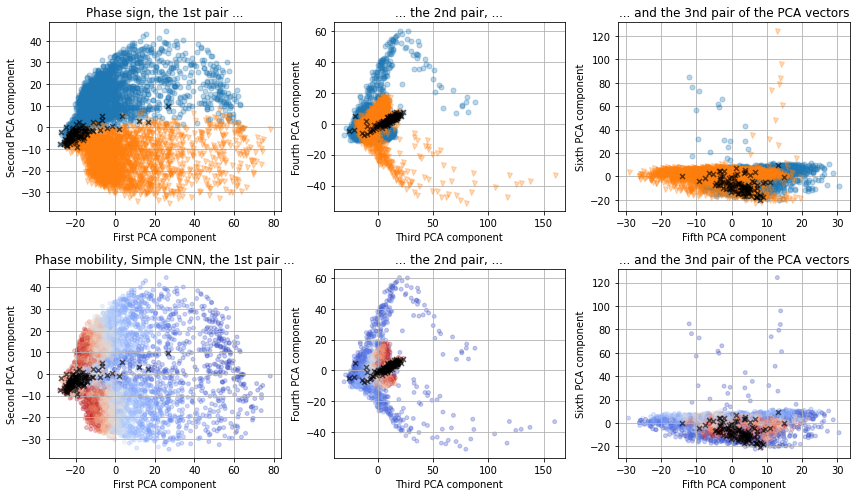

In [23]:
def plot_panel(feature_vector):
    """Plot the result panel."""
    # Reduce the dimensionality
    pca = sklearn.decomposition.PCA(n_components=100)
    reduced = pca.fit_transform(feature_vector)
    print('*** Explained Variation Ratio (Cummulative):', [
        round(sum(pca.explained_variance_ratio_[:i]), 2) for i in range(1, 10)])
    
    # Plot the results (positive vs negative)
    fig, axes = plt.subplots(2, 3, figsize=(12, 7))
    plot_clusters(
        fig, axes[0][0], k=2, instances=reduced, title='Phase sign, the 1st pair ...',
        labels=connectivity['+'], legend=False)
    plot_clusters(
        fig, axes[0][1], k=2, instances=reduced[:,2:], title='... the 2nd pair, ...',
         xtitle='Third PCA component', ytitle='Fourth PCA component',
        labels=connectivity['+'], legend=False)
    plot_clusters(
        fig, axes[0][2], k=2, instances=reduced[:,4:], title='... and the 3nd pair of the PCA vectors',
         xtitle='Fifth PCA component', ytitle='Sixth PCA component',
        labels=connectivity['+'], legend=False)

    # Plot the results (mobility)
    color_value = numpy.where(parameters.frac > 0, parameters.mobA, parameters.mobB)
    plot_pca(
        fig, axes[1][0], k=2, instances=reduced, title='Phase mobility, Simple CNN, the 1st pair ...',
        color=color_value)
    plot_pca(
        fig, axes[1][1], k=2, instances=reduced[:,2:], title='... the 2nd pair, ...',
         xtitle='Third PCA component', ytitle='Fourth PCA component',
        color=color_value)
    plot_pca(
        fig, axes[1][2], k=2, instances=reduced[:,4:], title='... and the 3nd pair of the PCA vectors',
         xtitle='Fifth PCA component', ytitle='Sixth PCA component',
        color=color_value)
    
# Plot
plot_panel(feature_v1)

**Interpretation:** Using a simple CNN we were able to get a good quality embedding. The direction of the first principal component sorts the instances with respect to the mobility and the second principal direction with respect to the phase fraction. All SC instances are grouped together.

We know, that during training, the lower layers generalize while the upper layers, specialize. Therefore, in the second test, we remove one additional layer and we compute the feature vectors once again.

In [24]:
# Remove the last 2 layer of the model
mxbis = tensorflow.keras.models.Model(
    inputs=m1.input, outputs=m1.layers[-4].output)
mxbis.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 64)        4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       204928    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)        

In [25]:
# Make inference for different patches and average the results
feature_v1bis = calculate_feature_vector(mxbis, data=data3)
feature_v1bis.shape

(4998, 16384)

*** Explained Variation Ratio (Cummulative): [0.09, 0.14, 0.16, 0.18, 0.19, 0.19, 0.2, 0.21, 0.21]


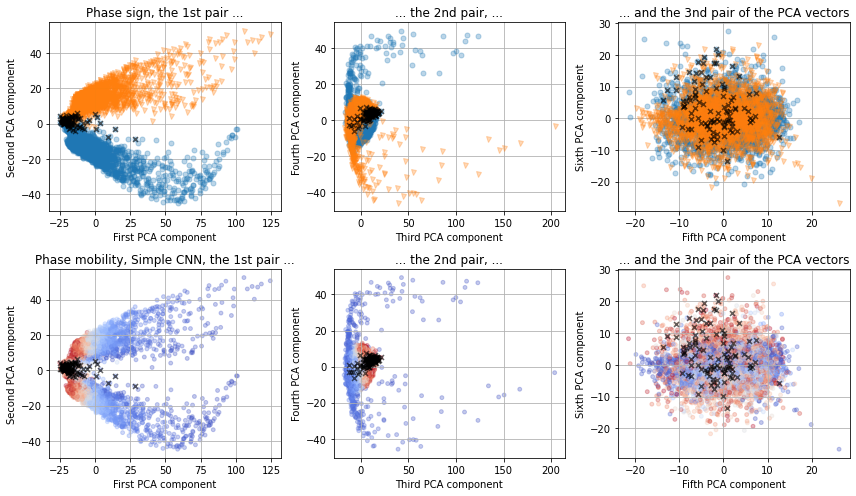

In [26]:
# Plot the panel results
plot_panel(feature_v1bis)

**Interpretation:** The separation between the positive and the negative layer is even more profound in this representation. However, this representation has lower explained cumulative variation ratio. The sum of the explained variation in the first 10 dimensions is just 0.24.

### ResNet-34

We repeat now the experiment using a more sophisticated model, namely ResNet-34. This model shares similar architecture to ResNet-50, it has just smaller number of layers.

In [27]:
class ResidualUnit(tensorflow.keras.layers.Layer):
    """Residential Unit for ResNet. Adapted from the book of Aurélien Géron."""
    
    def __init__(self, filters, channels=3, strides=1, activation="relu", **kwargs):
        """Initialization."""
        super().__init__(**kwargs)
        self.activation = tensorflow.keras.activations.get(activation)
        self.main_layers = [
            tensorflow.keras.layers.Conv2D(
                filters, kernel_size=(3, 3), strides=strides,
                padding="same", use_bias=False),  # TODO: zero pading is dangerous... Use something else?
            tensorflow.keras.layers.BatchNormalization(),
            self.activation,
            tensorflow.keras.layers.Conv2D(
                filters, kernel_size=(3, 3), strides=1,
                padding="same", use_bias=False),
            tensorflow.keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                tensorflow.keras.layers.Conv2D(
                    filters, kernel_size=(1, 1), strides=strides,
                    padding="same", use_bias=False),
                tensorflow.keras.layers.BatchNormalization()]

    def call(self, inputs):
        """Build the residual unit."""
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:  # happens only if strides > 1
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [28]:
# Define ResNet34
m2 = tensorflow.keras.models.Sequential()
m2.add(tensorflow.keras.layers.Conv2D(
    64, kernel_size=(7, 7), strides=2,
    input_shape=(128, 128, 3), padding="valid", use_bias=False))  # Changed from same
m2.add(tensorflow.keras.layers.BatchNormalization())
m2.add(tensorflow.keras.layers.Activation("relu"))
m2.add(tensorflow.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))

prev_filters = 64
for filters in [64]*3 + [128]*4 + [256]*6 + [512]*3:
    strides = 1 if filters == prev_filters else 2
    m2.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
    
m2.add(tensorflow.keras.layers.GlobalAvgPool2D())
m2.add(tensorflow.keras.layers.Flatten())
m2.add(tensorflow.keras.layers.Dense(NO_AUXILIARY_CLASSES, activation="softmax"))

m2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 61, 61, 64)        9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 61, 61, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 61, 61, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 31, 31, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 31, 31, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 31, 31, 64)       

In [29]:
# Compile
m2.compile(
    optimizer=tensorflow.keras.optimizers.Adam(0.0002),
    loss=tensorflow.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[
        tensorflow.keras.metrics.CategoricalAccuracy(name='acc1'),
        tensorflow.keras.metrics.TopKCategoricalAccuracy(k=5, name='acc5')]
)

# Define the early stopping procedure 
callback = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_acc1', patience=2, min_delta=0.001, mode='max'
)

# Train
m2_log =  m2.fit(
    train_data, train_y, epochs=10, verbose=1,
    validation_data=(val_data, val_y), callbacks=[callback]
)

Epoch 1/10
512/512 [==============================] - 32s 62ms/step - loss: 4.4448 - acc1: 0.0437 - acc5: 0.1781 - val_loss: 12.4438 - val_acc1: 0.0078 - val_acc5: 0.0547
Epoch 2/10
512/512 [==============================] - 32s 62ms/step - loss: 3.5659 - acc1: 0.0961 - acc5: 0.3411 - val_loss: 4.4191 - val_acc1: 0.0664 - val_acc5: 0.2773
Epoch 3/10
512/512 [==============================] - 32s 62ms/step - loss: 3.2537 - acc1: 0.1379 - acc5: 0.4354 - val_loss: 3.6074 - val_acc1: 0.1133 - val_acc5: 0.3750
Epoch 4/10
512/512 [==============================] - 32s 62ms/step - loss: 2.9779 - acc1: 0.1884 - acc5: 0.5189 - val_loss: 3.2876 - val_acc1: 0.1484 - val_acc5: 0.4570
Epoch 5/10
512/512 [==============================] - 32s 62ms/step - loss: 2.7025 - acc1: 0.2433 - acc5: 0.6060 - val_loss: 4.6574 - val_acc1: 0.0977 - val_acc5: 0.3086
Epoch 6/10
512/512 [==============================] - 32s 62ms/step - loss: 2.4489 - acc1: 0.2999 - acc5: 0.6843 - val_loss: 4.0555 - val_acc1: 0.125

In [30]:
# Remove the last layer of the model
mx = tensorflow.keras.models.Model(
    inputs=m2.input, outputs=m2.layers[-3].output)

# Make inference for different patches and average the results
feature_v2 = calculate_feature_vector(mx, data=data3)
feature_v2.shape

(4998, 512)

*** Explained Variation Ratio (Cummulative): [0.3, 0.55, 0.7, 0.79, 0.84, 0.88, 0.91, 0.93, 0.94]


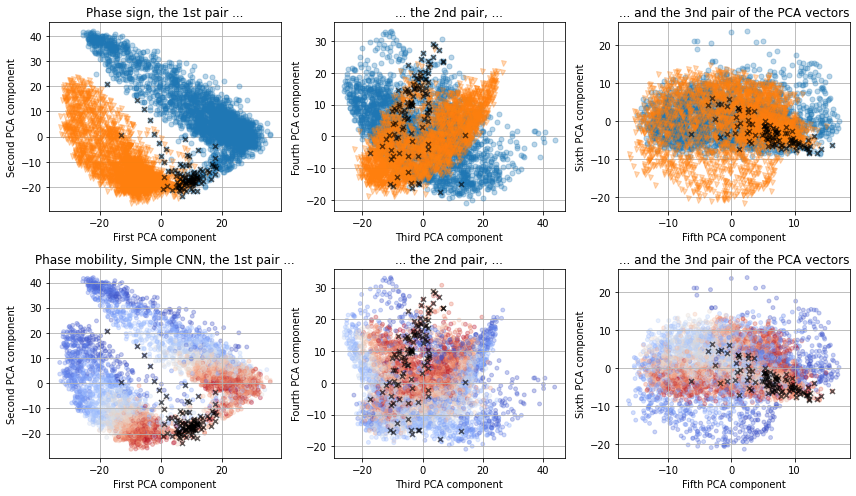

In [31]:
# Plot the panel results
plot_panel(feature_v2)

**Interpretation:** The separation between the positive and negative phase is visible. The instances are arranged with respect to the value of the mobility of the majority phase. The SC instances are grouped together. Those results resemble a bit the results that we obtained from the ResNet-50 pre-trained on the ImageNet dataset (see Section 2).

### Fine-Tune

In the last test, we use the transfer learning technique, by fine-tuning the pre-trained ResNet-50 model.

In [32]:
# Transfer Learning (based on ResNet)
m3 = tensorflow.keras.Sequential([
    tensorflow_hub.KerasLayer(
        "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4",
        trainable=True, arguments=dict(batch_norm_momentum=0.997)),
    tensorflow.keras.layers.Dropout(0.25),
    tensorflow.keras.layers.Dense(NO_AUXILIARY_CLASSES, activation='softmax')
])
m3.build([None, 128, 128, 3])
m3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
Total params: 24,089,344
Trainable params: 24,043,904
Non-trainable params: 45,440
_________________________________________________________________


In [33]:
# Compile
m3.compile(
    optimizer=tensorflow.keras.optimizers.Adam(0.0005),
    loss=tensorflow.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=[
        tensorflow.keras.metrics.CategoricalAccuracy(name='acc1'),
        tensorflow.keras.metrics.TopKCategoricalAccuracy(k=5, name='acc5')]
)

# Train
callback = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_acc1', patience=2, min_delta=0.001, mode='max'
)

m3_log =  m3.fit(
    train_data, train_y, epochs=10, verbose=1,
    validation_data=(val_data, val_y), callbacks=[callback]
)

Epoch 1/10
512/512 [==============================] - 51s 100ms/step - loss: 4.2098 - acc1: 0.0807 - acc5: 0.2936 - val_loss: 6.8275 - val_acc1: 0.0625 - val_acc5: 0.2188TA: 4s - loss: 4.2 - ETA: 1s - loss: 4.2280 - acc1: 0.07
Epoch 2/10
512/512 [==============================] - 51s 99ms/step - loss: 3.1598 - acc1: 0.2147 - acc5: 0.5676 - val_loss: 8.0795 - val_acc1: 0.0703 - val_acc5: 0.2852 - ac - ETA: 1s - loss: 3.1729 - acc1: 0.2122 - acc5: 0 - ETA: 1s - loss: 3.1705 - acc1: 0.2118 - acc5: 0.5 - ETA: 0s - loss: 3.1688 - acc1: 0.2122 - acc5:  - ETA: 0s - loss: 3.1631 - acc1: 0.2135 - acc5: 0
Epoch 3/10
512/512 [==============================] - 51s 100ms/step - loss: 2.5933 - acc1: 0.3535 - acc5: 0.7407 - val_loss: 3.4481 - val_acc1: 0.2539 - val_acc5: 0.6016
Epoch 4/10
512/512 [==============================] - 51s 100ms/step - loss: 2.0594 - acc1: 0.5139 - acc5: 0.8636 - val_loss: 3.0162 - val_acc1: 0.3438 - val_acc5: 0.6836
Epoch 5/10
512/512 [==============================] - 5

In [34]:
# Remove the last layer of the model
mx = tensorflow.keras.models.Model(
    inputs=m3.input, outputs=m3.layers[-3].output)

# Make inference for different patches and average the results
feature_v3 = calculate_feature_vector(mx, data=data3)
feature_v3.shape

(4998, 2048)

*** Explained Variation Ratio (Cummulative): [0.33, 0.42, 0.52, 0.58, 0.62, 0.66, 0.69, 0.72, 0.74]


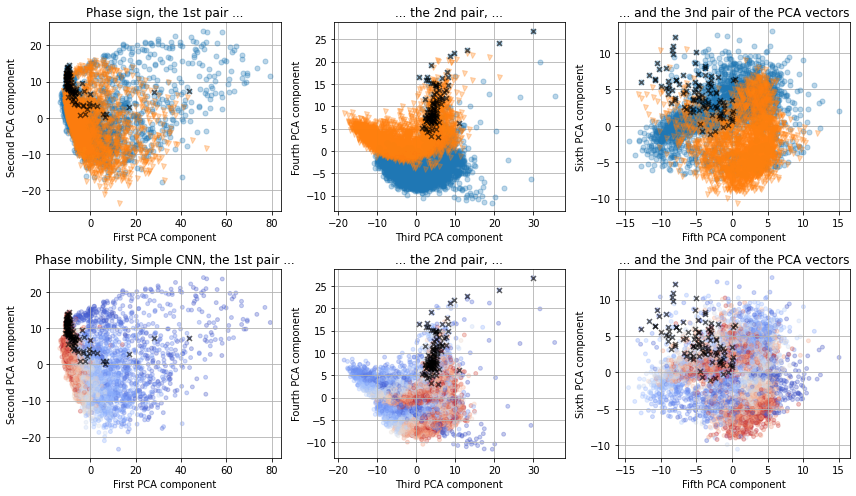

In [35]:
# Plot the panel results
plot_panel(feature_v3)

**Interpretation:** Note, that our accuracy on the validation set significantly increased, reaching in one moment over 0.5 top-1 accuracy. With 256 different classes it is very good result. However, we should also keep in mind, that the examples from the validation set are to a certain degree, correlated with the training examples. Therefore, we should take that results with a grain of salt.

We see also, that despite the fact that the accuracy of that model on the validation set is more then twice larger than in the previous examples, the embedding is not objectively better then the previous ones. We might even claim, that the separation between the cases with the positive or the negative phase being dominant is not as clear as in the previous embeddings.

## Section 5: Clustering

We test the effects of various feature representations on the clustering task.

We use the k-Means with the same choice of the centroid initialization algorithm as previously (k-means++). We run the algorithm 10 time and we chose the results that correspond to the lowest inertia.

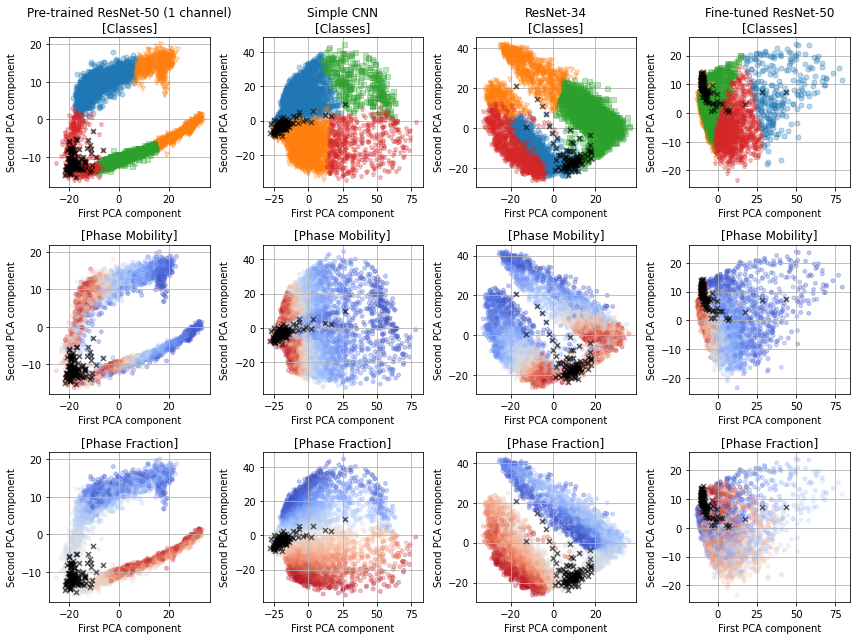

In [132]:
def plot_clusters_panel(fig, ax, vector, title1, title2=None, title3=None):
    """Plot the most characteristic cases from each cluster."""
    kmeans = sklearn.cluster.KMeans(n_clusters=4, n_init=10, init='k-means++').fit(vector)
    reduced = sklearn.decomposition.PCA(n_components=4).fit_transform(vector)

    # First two components
    plot_clusters(
        fig, ax[0], k=5, instances=reduced, labels=kmeans.labels_,
        sc=connectivity.sc, legend=False, title=title1)
    plot_pca(
        fig, ax[1], k=2, instances=reduced, title='[Phase Mobility]',
        color=numpy.where(parameters.frac > 0, parameters.mobA, parameters.mobB))
    plot_pca(
        fig, ax[2], k=2, instances=reduced, title='[Phase Fraction]',
        color=parameters.frac)


# Plot
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
plot_clusters_panel(
    fig, ax=(axes[0][0], axes[1][0], axes[2][0]),
    vector=features_channel1, title1='Pre-trained ResNet-50 (1 channel)\n[Classes]')
plot_clusters_panel(
    fig, ax=(axes[0][1], axes[1][1], axes[2][1]),
    vector=feature_v1, title1='Simple CNN\n[Classes]')
plot_clusters_panel(
    fig, ax=(axes[0][2], axes[1][2], axes[2][2]),
    vector=feature_v2, title1='ResNet-34\n[Classes]')
plot_clusters_panel(
    fig, ax=(axes[0][3], axes[1][3], axes[2][3]),
    vector=feature_v3, title1='Fine-tuned ResNet-50\n[Classes]')

**Interpretation:** We mapped the instances to the feature space and then projected on the plane corresponding to the first two largest principal directions. The first row shows the clusters obtained by using the k-Means algorithm. For the illustrative purposes, we picked k=4. We see however, that in fact, there is no clear clusters. By moving in the feature space, the values of parameters change in a continuous manner.

Those results suggest also, that depending on our task, we might prefer different embeddings. The first embedding might be useful in classification task (e.g., the separation between the cases where positive phase is dominant and the cases where the negative phase is dominant is the most profound). However, instances are more "squeezed" together. This may be a disadvantage in some regression tasks (e.g., if we tried to map the input back to the parameter space). The second embedding could be more suitable in that regard.

## Summary

We have presented a method of learning a feature vector representation in a fully unsupervised manner. Additionally, by training our own feature vector mapping, we were able to incorporate specific symmetries of our problem, such as the rotational invariance and periodic boundary conditions.

This shows an effective an a reliable alternative to standard image embedding trained on large annotated image datasets. 